In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Order_System_2.csv')

# Examine the contents
print(df.head())

                     Timestamp     Platform  \
0  2023/06/25 12:41:55 pm EEST         Uber   
1  2023/06/25 12:42:55 pm EEST  Mr Delivery   
2  2023/06/25 12:46:36 pm EEST       Window   
3  2023/06/25 12:48:42 pm EEST       Window   
4  2023/06/25 12:50:03 pm EEST         Uber   

                             Pizzas [1] Pizzas [2] Pizzas [3] Extra Topping  \
0  Margie;Pig n Paradise;Mushroom Cloud     Margie        NaN           NaN   
1                                 Champ        NaN        NaN           NaN   
2                 Margie;Pig n Paradise        NaN        NaN           NaN   
3                        Feisty Italian        NaN        NaN           NaN   
4                  Margie;Sausage Party     Margie        NaN           NaN   

  Preparation Time (Minutes)  
0                      11:50  
1                      11:45  
2                      11:46  
3                      11:55  
4                      11:59  


In [2]:
# Fill missing values for pizzas and extra toppings with "None"
df.fillna({'Pizzas [2]': 'None', 'Pizzas [3]': 'None', 'Extra Topping': 'None'}, inplace=True)

# Convert 'Preparation Time (Minutes)' to total seconds for uniformity and easier calculations
def convert_to_seconds(time_str):
    if pd.isnull(time_str):
        return None
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:  # In case the format is unexpected
        return None

df['Preparation Time (Seconds)'] = df['Preparation Time (Minutes)'].apply(convert_to_seconds)

# Drop the original 'Preparation Time (Minutes)' column as it's no longer needed
df.drop(columns='Preparation Time (Minutes)', inplace=True)

# Display the info to verify the changes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp                   8319 non-null   object 
 1   Platform                    8059 non-null   object 
 2   Pizzas [1]                  8154 non-null   object 
 3   Pizzas [2]                  8319 non-null   object 
 4   Pizzas [3]                  8319 non-null   object 
 5   Extra Topping               8319 non-null   object 
 6   Preparation Time (Seconds)  49 non-null     float64
dtypes: float64(1), object(6)
memory usage: 455.1+ KB


In [3]:
# Try to parse the timestamps without specifying a format and with infer_datetime_format set to True
# Ignore the timezone during parsing for now
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', infer_datetime_format=True)

# Set the 'Timestamp' column as the index if it's not already set
if df.index.name != 'Timestamp':
    df.set_index('Timestamp', inplace=True)

# Try to resample now that the index is a DatetimeIndex
try:
    daily_data = df.resample('D').sum()  # This should now work without errors.
    success = True
except TypeError as e:
    success = False
    error_message = str(e)

success, daily_data.head() if success else error_message



C:\Users\cparker\AppData\Local\Temp\ipykernel_3548\2204349098.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', infer_datetime_format=True)
C:\Users\cparker\AppData\Local\Temp\ipykernel_3548\2204349098.py:3: FutureWarning: Parsed string "2023/06/25 12:41:55 pm EEST" included an un-recognized timezone "EEST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', infer_datetime_format=True)


(True,
                                                      Platform  \
 Timestamp                                                       
 2023-06-25  UberWindowUberWindowUberUberUberWindowWindowUb...   
 2023-06-26  UberMr DeliveryWindowWindowMr DeliveryMr Deliv...   
 2023-06-27  Mr DeliveryWindowBoltMr DeliveryMr DeliveryBol...   
 2023-06-28  UberMr DeliveryWindowWindowUberUberWindowUberU...   
 2023-06-29  WindowWindowWindowUberUberWindowUberUberWindow...   
 
                                                    Pizzas [1]  \
 Timestamp                                                       
 2023-06-25  MargieChamp;Mish-Mash;Feisty ItalianMish-MashC...   
 2023-06-26  MargieChampVegan HarvestMushroom CloudMargiePi...   
 2023-06-27  MargieChampChampFeisty ItalianSausage PartyCha...   
 2023-06-28  Margie;ChampMargie;SpudPig n ParadiseMargieMus...   
 2023-06-29  MargieMargiePig n ParadiseMargie;ChampMushroom...   
 
                                                    Pizzas [2]  \

In [4]:
# Aggregate orders daily
daily_orders = df.resample('D').size()

# Create a DataFrame for further feature engineering
df_daily = pd.DataFrame(daily_orders, columns=['Total Orders'])

# Feature Engineering

# Day of the week (0=Monday, 6=Sunday)
df_daily['Day of Week'] = df_daily.index.dayofweek

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df_daily['Season'] = df_daily.index.month.apply(get_season)

# Display the first few rows to verify
df_daily.head()


AttributeError: 'Index' object has no attribute 'apply'

In [5]:
# Manually define South African public holidays for 2023 and 2024 within our dataset's date range
sa_public_holidays = [
    '2023-01-01', '2023-03-21', '2023-04-07', '2023-04-10', '2023-04-27', '2023-05-01',
    '2023-06-16', '2023-08-09', '2023-09-24', '2023-12-16', '2023-12-25', '2023-12-26',
    '2024-01-01', '2024-03-21', '2024-04-19', '2024-04-22', '2024-04-27', '2024-05-01',
    '2024-06-16', '2024-08-09', '2024-09-24', '2024-12-16', '2024-12-25', '2024-12-26'
]

# Convert to datetime for comparison
sa_public_holidays = pd.to_datetime(sa_public_holidays)

# Create a binary feature for public holidays
df_daily['Is Public Holiday'] = df_daily.index.isin(sa_public_holidays).astype(int)

# Display the updated DataFrame
df_daily.head()



,Total Orders,Day of Week,Is Public Holiday
Timestamp,,,
2023-06-25,49,6,0
2023-06-26,11,0,0
2023-06-27,33,1,0
2023-06-28,10,2,0
2023-06-29,31,3,0


In [6]:
# Correctly apply the get_season function
df_daily['Season'] = df_daily.index.month.map(get_season)

# Display the first few rows to verify corrections
df_daily.head()



,Total Orders,Day of Week,Is Public Holiday,Season
Timestamp,,,,
2023-06-25,49,6,0,Winter
2023-06-26,11,0,0,Winter
2023-06-27,33,1,0,Winter
2023-06-28,10,2,0,Winter
2023-06-29,31,3,0,Winter


In [7]:
# Fill missing values for pizzas and extra toppings with "None"
df.fillna({'Pizzas [2]': 'None', 'Pizzas [3]': 'None', 'Extra Topping': 'None'}, inplace=True)

# Convert 'Preparation Time (Minutes)' to total seconds for uniformity and easier calculations
def convert_to_seconds(time_str):
    if pd.isnull(time_str):
        return None
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:  # In case the format is unexpected
        return None

df['Preparation Time (Seconds)'] = df['Preparation Time (Minutes)'].apply(convert_to_seconds)

# Drop the original 'Preparation Time (Minutes)' column as it's no longer needed
df.drop(columns='Preparation Time (Minutes)', inplace=True)

# Display the info to verify the changes
df.info()


KeyError: 'Preparation Time (Minutes)'

In [8]:
# Correctly apply the get_season function
df_daily['Season'] = df_daily.index.month.map(get_season)

# Display the first few rows to verify corrections
df_daily.head()


,Total Orders,Day of Week,Is Public Holiday,Season
Timestamp,,,,
2023-06-25,49,6,0,Winter
2023-06-26,11,0,0,Winter
2023-06-27,33,1,0,Winter
2023-06-28,10,2,0,Winter
2023-06-29,31,3,0,Winter


In [9]:
# Define a function to count pizzas from the column data
def count_pizzas(pizza_list):
    # Split the string by semicolon and return the number of pizzas
    return len(str(pizza_list).split(';')) if not pd.isnull(pizza_list) else 0

# Apply the function to each pizza column and sum the results for each row
df['Total Pizzas'] = df.apply(lambda row: count_pizzas(row['Pizzas [1]']) +
                                          count_pizzas(row['Pizzas [2]']) +
                                          count_pizzas(row['Pizzas [3]']), axis=1)

# Now aggregate this new total by day
daily_pizza_counts = df.resample('D')['Total Pizzas'].sum()

# Update our daily DataFrame with the new pizza counts
df_daily['Total Pizzas'] = daily_pizza_counts

# Re-display the updated DataFrame
df_daily.head()


,Total Orders,Day of Week,Is Public Holiday,Season,Total Pizzas
Timestamp,,,,,
2023-06-25,49,6,0,Winter,169
2023-06-26,11,0,0,Winter,33
2023-06-27,33,1,0,Winter,111
2023-06-28,10,2,0,Winter,36
2023-06-29,31,3,0,Winter,108


In [10]:
# Function to flatten and count pizza types for a given day's orders
def count_pizza_types(dataframe):
    # Flatten the list of lists containing the pizza types
    all_pizzas = [pizza for sublist in dataframe for pizza in sublist if pizza != 'None']
    # Count the occurrences of each pizza type
    pizza_counts = pd.Series(all_pizzas).value_counts()
    return pizza_counts

# Extract pizza types from the 'Pizzas' columns, count them, and store them in a new DataFrame
pizza_types_df = df.apply(lambda row: count_pizza_types([str(row['Pizzas [1]']).split(';'), 
                                                         str(row['Pizzas [2]']).split(';'), 
                                                         str(row['Pizzas [3]']).split(';')]), axis=1)

# Summarize the counts daily
daily_pizza_type_counts = pizza_types_df.resample('D').sum().fillna(0).astype(int)

# Merge the counts with the daily DataFrame
df_daily = df_daily.merge(daily_pizza_type_counts, left_index=True, right_index=True, how='left')

# Display the updated DataFrame with the pizza type features
df_daily.head()




,Total Orders,Day of Week,Is Public Holiday,Season,Total Pizzas,Build Your Own,Champ,Feisty Italian,Lekker'izza,Margie,...,Mushroom Cloud,Owen,Pig n Paradise,Poppa's,Sausage Party,Spud,Sunshine Margherita,Vegan Harvest,Zesty Zucchini,nan
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-25,49,6,0,Winter,169,0,16,7,0,20,...,5,0,19,0,2,0,0,5,0,1
2023-06-26,11,0,0,Winter,33,0,3,0,0,5,...,1,0,3,0,0,0,0,1,0,1
2023-06-27,33,1,0,Winter,111,0,13,7,0,12,...,2,0,4,2,3,2,0,3,0,2
2023-06-28,10,2,0,Winter,36,0,3,0,0,6,...,3,0,3,0,0,2,0,0,0,0
2023-06-29,31,3,0,Winter,108,0,14,2,0,15,...,6,0,5,1,0,5,0,1,0,0


In [11]:
# Define a function to accurately count total pizzas per row, considering all pizza columns
def count_total_pizzas(row):
    # Create a list of pizzas from all columns, split by ';' and filter out 'None'
    pizzas = [item for sublist in [str(row[col]).split(';') for col in ['Pizzas [1]', 'Pizzas [2]', 'Pizzas [3]']] 
              for item in sublist if item != 'None']
    return len(pizzas)

# Recalculate the 'Total Pizzas' column with the correct counting
df['Total Pizzas Corrected'] = df.apply(count_total_pizzas, axis=1)

# Aggregate this new total by day
daily_pizza_counts_corrected = df.resample('D')['Total Pizzas Corrected'].sum()

# Update our daily DataFrame with the corrected pizza counts
df_daily['Total Pizzas'] = daily_pizza_counts_corrected

# Display the updated DataFrame to verify the correction
df_daily.head()



,Total Orders,Day of Week,Is Public Holiday,Season,Total Pizzas,Build Your Own,Champ,Feisty Italian,Lekker'izza,Margie,...,Mushroom Cloud,Owen,Pig n Paradise,Poppa's,Sausage Party,Spud,Sunshine Margherita,Vegan Harvest,Zesty Zucchini,nan
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-25,49,6,0,Winter,81,0,16,7,0,20,...,5,0,19,0,2,0,0,5,0,1
2023-06-26,11,0,0,Winter,14,0,3,0,0,5,...,1,0,3,0,0,0,0,1,0,1
2023-06-27,33,1,0,Winter,55,0,13,7,0,12,...,2,0,4,2,3,2,0,3,0,2
2023-06-28,10,2,0,Winter,18,0,3,0,0,6,...,3,0,3,0,0,2,0,0,0,0
2023-06-29,31,3,0,Winter,54,0,14,2,0,15,...,6,0,5,1,0,5,0,1,0,0


In [12]:
# Manually define South African public holidays for 2023 and 2024 within our dataset's date range
sa_public_holidays = [
    '2023-01-01', '2023-03-21', '2023-04-07', '2023-04-10', '2023-04-27', '2023-05-01',
    '2023-06-16', '2023-08-09', '2023-09-24', '2023-12-16', '2023-12-25', '2023-12-26',
    '2024-01-01', '2024-03-21', '2024-04-19', '2024-04-22', '2024-04-27', '2024-05-01',
    '2024-06-16', '2024-08-09', '2024-09-24', '2024-12-16', '2024-12-25', '2024-12-26'
]

# Convert to datetime for comparison
sa_public_holidays = pd.to_datetime(sa_public_holidays)

# Create a binary feature for public holidays
df_daily['Is Public Holiday'] = df_daily.index.isin(sa_public_holidays).astype(int)

# Display the updated DataFrame
df_daily.head()


,Total Orders,Day of Week,Is Public Holiday,Season,Total Pizzas,Build Your Own,Champ,Feisty Italian,Lekker'izza,Margie,...,Mushroom Cloud,Owen,Pig n Paradise,Poppa's,Sausage Party,Spud,Sunshine Margherita,Vegan Harvest,Zesty Zucchini,nan
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-25,49,6,0,Winter,81,0,16,7,0,20,...,5,0,19,0,2,0,0,5,0,1
2023-06-26,11,0,0,Winter,14,0,3,0,0,5,...,1,0,3,0,0,0,0,1,0,1
2023-06-27,33,1,0,Winter,55,0,13,7,0,12,...,2,0,4,2,3,2,0,3,0,2
2023-06-28,10,2,0,Winter,18,0,3,0,0,6,...,3,0,3,0,0,2,0,0,0,0
2023-06-29,31,3,0,Winter,54,0,14,2,0,15,...,6,0,5,1,0,5,0,1,0,0


In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the 'Total Pizzas' column to check stationarity
adf_test_total_pizzas = adfuller(df_daily['Total Pizzas'].dropna())

adf_test_total_pizzas_results = {
    'ADF Statistic': adf_test_total_pizzas[0],
    'p-value': adf_test_total_pizzas[1],
    'Critical Values': adf_test_total_pizzas[4],
}

adf_test_total_pizzas_results


{'ADF Statistic': -1.5718461024964732,
 'p-value': 0.49771886584000946,
 'Critical Values': {'1%': -3.4912451337340342,
  '5%': -2.8881954545454547,
  '10%': -2.5809876033057852}}

In [16]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define the p, d, q parameters to take any value between 0 and 2, and s to take seasonal length
p = d = q = range(0, 3)
s = 7  # Assuming a weekly seasonality

# Generate all different combinations of p, d, q and seasonal p, d, q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

# Grid search for the optimal SARIMA parameters
best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_total_pizzas,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)
            
            # Compare with the best model so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

best_parameters = {
    'aic': best_aic,
    'pdq': best_pdq,
    'seasonal_pdq': best_seasonal_pdq
}

best_parameters



c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\cparker\AppData\Local\anaconda3\env

{'aic': 556.9867965223899, 'pdq': (0, 1, 2), 'seasonal_pdq': (0, 2, 2, 7)}

In [17]:
# Fit the SARIMA model with the best parameters
sarima_model = SARIMAX(train_total_pizzas,
                       order=best_parameters['pdq'],
                       seasonal_order=best_parameters['seasonal_pdq'],
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fitted_model = sarima_model.fit(disp=False)

# Make predictions for the same time period as the test set
sarima_forecast = sarima_fitted_model.get_forecast(steps=len(test))
sarima_predicted_mean = sarima_forecast.predicted_mean

# Calculate RMSE
rmse = mean_squared_error(test['Total Pizzas'], sarima_predicted_mean, squared=False)

# Prepare the forecast DataFrame for plotting
forecast_comparison_df = test[['Total Pizzas']].copy()
forecast_comparison_df['SARIMA Forecast'] = sarima_predicted_mean

rmse, forecast_comparison_df.head()


c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\cparker\AppData\Local\anaconda3\envs\new_env_name\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(22.562657759987072,
             Total Pizzas  SARIMA Forecast
 Timestamp                                
 2023-10-02             0        -5.303671
 2023-10-03            24        14.543851
 2023-10-04            49        26.243585
 2023-10-05            67        30.736660
 2023-10-06           109        75.249782)

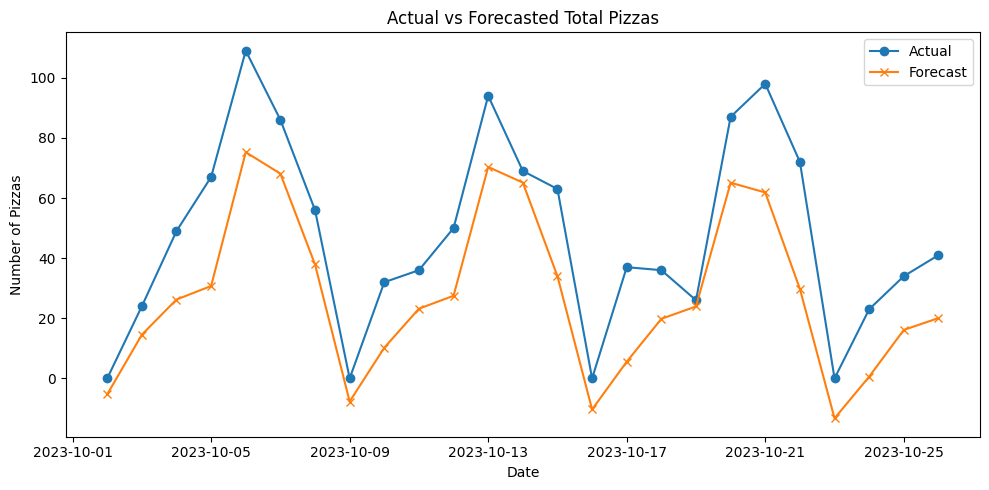

Root Mean Squared Error: <function rmse at 0x0000026F6FDBBE20>


<function statsmodels.tools.eval_measures.rmse(x1, x2, axis=0)>

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Assuming 'forecast_comparison_df' contains your SARIMA forecasts
# And 'rmse' is the Root Mean Squared Error of your forecast

# Plot the actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(forecast_comparison_df.index, forecast_comparison_df['Total Pizzas'], label='Actual', marker='o')
plt.plot(forecast_comparison_df.index, forecast_comparison_df['SARIMA Forecast'], label='Forecast', marker='x')
plt.title('Actual vs Forecasted Total Pizzas')
plt.xlabel('Date')
plt.ylabel('Number of Pizzas')
plt.legend()
plt.tight_layout()
plt.show()

# Print the Root Mean Squared Error
print(f'Root Mean Squared Error: {rmse}')

rmse


In [21]:
# Calculate Mean Squared Error for reference
mse = mean_squared_error(forecast_comparison_df['Total Pizzas'], forecast_comparison_df['SARIMA Forecast'])
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 509.0735251943049
